![](./figures/Logo.PNG)

## In this part of the tutorial, you will
* use grid sampling, random sampling and Latin Hypercube sampling
* analyse the metric results of sampled parameters

---

# 3 - Sampling of input parameters

---

## 1. About sampling 

Sampling involves selecting a subset of potential input parameters from defined ranges. A goal of the process is to understand how variations in input parameters impact the output of computer models, aiding in model optimization and analysis. Typically, three different sampling strategies are used:


#### Grid Sampling
Input parameters are selected at even intervals within specified parameter bounds. A derived approach is **stratified sampling**, where the parameters are not assigned to the grid intersections but are random point is drawn in each grid cell. 

#### Random Sampling
Random sampling within parameter bounds from a uniform distribution. This is also known as Monte-Carlo sampling.

#### Latin Hypercube Sampling (LHS)
Systematic and efficient technique for selecting a diverse set of input parameter combinations within defined ranges, minimizing redundancy and ensuring a more representative coverage of the parameter space in computational experiments.

It work's like this:
1. Parameter Ranges Definition: Define the ranges for each input parameter that you want to sample in your study.
2. Divide Ranges: Divide each parameter range into equal intervals, corresponding to the desired number of samples or scenarios.
3. Create a Matrix: Create a Latin square matrix, where each row and column represents one interval of each parameter. The Latin property ensures that each interval is sampled exactly once across rows and columns.
4. Random Permutation: Randomly permute the elements within each row of the matrix, ensuring that the samples are selected randomly within their respective intervals.
5. Select Samples: Choose one sample from each row of the matrix. These samples represent the selected combinations of input parameters for your simulation or experiment.

<center><img src="https://www.researchgate.net/publication/347334888/figure/fig1/AS:976080278138880@1609727081034/Comparison-of-random-stratified-and-latin-hypercube-samplings-with-16-points-d-2-M.png" style="max-width:50%"/></center>

| **Method**          | **Coverage**                       | **Bias**                 | **Complexity**  | **Marginal Distribution** |
|---------------------|------------------------------------|--------------------------|-----------------|---------------------------|
| Grid                | evenly spaced                      | low                      | simple          | discrete |
| Stratified          | randomly distributed               | low                      | simple          | roughly uniform |
| Random              | randomly distributed               | moderate (can be skewed) | simple          | roughly uniform  |
| LHS                 | evenly distributed in intervals    | low                      | moderate        | uniform  |

## 2. Using sampling

**Import packages**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
from scipy.interpolate import interp1d
import sys
sys.path.append('src/')
import HyMod
from ipywidgets import Dropdown, GridBox

**Defining signatures and objective functions**

In [2]:
def rmse(obs, sim):
    """
    Calculates the RMSE of simulated and observed streamflow
    obs :  The observed time series
    sim :  The simulated time series
    @returns : The RSME(obs,sim)
    """
    return np.sqrt(np.mean(np.square(np.subtract(obs, sim))))

def nse(obs, sim):
    """
    Calculates Nash Sutcliffe efficiency
    obs :  The observed time series
    sim :  The simulated time series
    @returns : nse
    """
    # range: negative infinity to 1
    # optimal value: 1
    r_nse = np.corrcoef(obs, sim)[0][1] 
    alpha_nse = np.divide(np.std(sim), np.std(obs))
    beta_nse = np.divide(np.subtract(np.mean(sim), np.mean(obs)), np.std(obs))
    nse = 2 * alpha_nse * r_nse - np.square(alpha_nse) - np.square(beta_nse)
    return nse

def hymod_func(param, precip, pet, objective_fun, runoff_obs, n_days):
    # run HyMod
    param = np.array([param[0], param[1], param[2], 1/param[3], 1/param[4]])
    runoff_sim, states, fluxes = HyMod.hymod_sim(param, precip, pet)
    result = objective_fun(runoff_obs[n_days:], runoff_sim[n_days:])
    return result

**Create and display interactive menus for selecting catchment**

In [11]:
# DO NOT ALTER! code to select the catchment and sample number

catchment_names = ["Siletz River, OR, USA", "Medina River, TX, USA", "Trout River, BC, Canada"]
catchment_dropdown = Dropdown(
    options=catchment_names,
    value=catchment_names[0],
    description='Catchment:',
    disabled=False)

# 2^5=32, 3^5=243, 4^5=1024 for grid sampling with 2, 3, 4 steps (options 50, 500 are downgraded to 32, 243 for grid, while random, lhs use 50, 500)
samples_dropdown = Dropdown(
    options=[32, 50, 243, 500, 1024],
    value=243,
    description='Samples:',
    disabled=False)

GridBox([catchment_dropdown, samples_dropdown])

GridBox(children=(Dropdown(description='Catchment:', options=('Siletz River, OR, USA', 'Medina River, TX, USA'…

**Read catchment data and prepare input data for models**

In [4]:
n_samples = samples_dropdown.value
# Read catchment data
catchment_name = catchment_dropdown.value
file_dic = {catchment_names[0]: "camels_14305500", catchment_names[1]: "camels_08178880", catchment_names[2]: "hysets_10BE007"}
df_obs = pd.read_csv(f"data/{file_dic[catchment_name]}.csv")
# Make sure the date is interpreted as a datetime object -> makes temporal operations easier
df_obs.date = pd.to_datetime(df_obs['date'], format='%Y-%m-%d')
# Select time frame
start_date = '2002-10-01'
end_date = '2006-09-30'
spinup_days = 365 

# Index frame by date
df_obs.set_index('date', inplace=True)
# Select time frame
df_obs = df_obs[start_date:end_date]
# Reformat the date for plotting
df_obs["date"] = df_obs.index.map(lambda s: s.strftime('%b-%d-%y'))
# Reindex
df_obs = df_obs.reset_index(drop=True)
# Select snow, precip, PET, streamflow and T
df_obs = df_obs[["snow_depth_water_equivalent_mean", "total_precipitation_sum","potential_evaporation_sum","streamflow", "temperature_2m_mean", "date"]]
# Rename variables
df_obs.columns = ["Snow [mm/day]", "P [mm/day]", "PET [mm/day]", "Q [mm/day]", "T [C]", "Date"]

# Prepare the data intput for both models
P = df_obs["P [mm/day]"].to_numpy()
evap = df_obs["PET [mm/day]"].to_numpy()
temp = df_obs["T [C]"].to_numpy()
q_obs = df_obs["Q [mm/day]"].to_numpy()

parameter_names = ["Sm", "beta", "alfa", "Rs", "Rf"] # define parameters names
bounds = [(0, 400), (0, 3), (0, 1), (8, 200), (1, 7)]  # set bounds for parameters

# set general plotting settings
colors = ["green", "orange", "purple"]
bins = int(np.sqrt(n_samples))

# set further config 
l_sampling_names = ["Grid sampling", "Random sampling", "LHS"]
l_obj_fun_names = ["RMSE", "NSE"]
dict_obj_fun = {l_obj_fun_names[0]: rmse, l_obj_fun_names[1]: nse}

**Grid sampling**

Creating samples. Grid sampling: 243 samples. Quasi-random sampling and LHS: 243 samples
Running model. This may take a while.
   ... model is running with parameter sets from: Grid sampling
        ... already done with parameter set id: 100
        ... already done with parameter set id: 200
   ... model is running with parameter sets from: Random sampling
        ... already done with parameter set id: 100
        ... already done with parameter set id: 200
   ... model is running with parameter sets from: LHS
        ... already done with parameter set id: 100
        ... already done with parameter set id: 200
Done. Now you may run the remaining python cells in this notebook independent of each other
Plotting parameter distributions


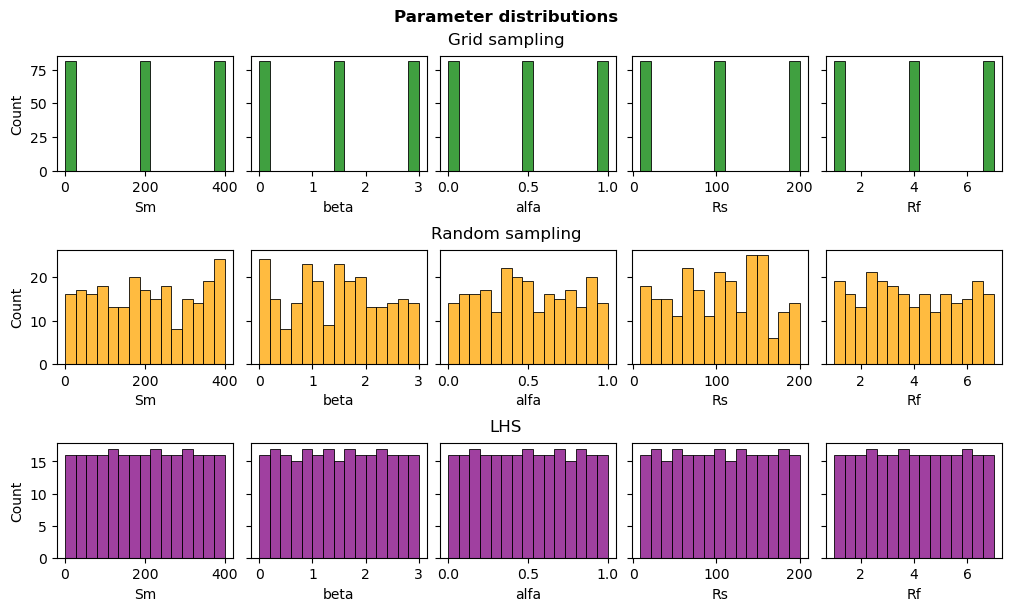

In [5]:
# Create random samples within the parameter bounds
samples_grd = []
samples_rnd = []
samples_lhs = []
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.qmc.LatinHypercube.html
lhs_sampler = qmc.LatinHypercube(d=len(parameter_names), optimization='random-cd')
sample_matrix = lhs_sampler.random(n=n_samples)  # Create relative samples [0, 1] (each col is a parameter, each row a set of relative samples)
len_of_grid = int(np.power(n_samples, 1/len(bounds)))
print(f"Creating samples. Grid sampling: {np.power(len_of_grid, 5)} samples. Quasi-random sampling and LHS: {n_samples} samples")

df_smp_grd = pd.DataFrame()
for i, bound in enumerate(bounds):
    low, high = bound
    # create samples using the parameter bounds
    sample_grd = np.linspace(low, high, len_of_grid)
    df_grd_tmp = pd.DataFrame(sample_grd, columns=[parameter_names[i]])
    if i == 0:
        df_smp_grd = df_grd_tmp
    else:
        df_smp_grd = df_smp_grd.merge(df_grd_tmp, how="cross")
        
    sample_rnd = np.random.default_rng().uniform(low, high, n_samples)  # random samples
    sample_lhs = np.interp(sample_matrix.T[i], [0, 1], [low, high])  # LHS samples
    samples_rnd.append(sample_rnd)
    samples_lhs.append(sample_lhs)  

# Turn samples into a matrix and transpose it so that each iteration gives us new sets
prmtr_sets_rnd = np.array(samples_rnd).T
prmtr_sets_lhs = np.array(samples_lhs).T
dict_prmtr_sets = {l_sampling_names[0]: df_smp_grd.values, l_sampling_names[1]: prmtr_sets_rnd, l_sampling_names[2]: prmtr_sets_lhs}

print("Running model. This may take a while.")
# Run HyMod for all the parameter sets and get the output
output = []
for sampling, prmtr_sets_smp in dict_prmtr_sets.items():
    print(f"   ... model is running with parameter sets from: {sampling}")
    for set_id, prmtr_smp in zip(range(0, n_samples), prmtr_sets_smp):
        for objective_fun_name in dict_obj_fun:
            metric_value = hymod_func(prmtr_smp, P, evap, dict_obj_fun[objective_fun_name], q_obs, spinup_days)
            for i, parameter_name in enumerate(parameter_names):
                # Save data in long format for easy plotting
                output.append({"Sampling": sampling, "Set": set_id, "Metric": objective_fun_name, "Metric value": metric_value,
                               "Parameter": parameter_name, "Parameter value": prmtr_smp[i]})
        if set_id%100 == 0 and set_id > 0:
            print(f"        ... already done with parameter set id: {set_id}")

df_metrics = pd.DataFrame.from_records(output)
#print(df_metrics)

# make dataframes from matrices
df_smp_rnd = pd.DataFrame(prmtr_sets_rnd, columns=parameter_names)
df_smp_lhs = pd.DataFrame(prmtr_sets_lhs, columns=parameter_names)
dict_dfs = {"Grid sampling": df_smp_grd, "Random sampling": df_smp_rnd, "LHS": df_smp_lhs}
print("Done. Now you may run the remaining python cells in this notebook independent of each other")

print("Plotting parameter distributions")
# plot parameter distributions
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
fig.suptitle('Parameter distributions', fontweight="bold")
subfigs = fig.subfigures(nrows=len(dict_dfs), ncols=1)
l_df_smp = []
for sampling_name, df_smp, subfig, color in zip(dict_dfs, dict_dfs.values(), subfigs, colors):
    subfig.suptitle(sampling_name)
    axes = subfig.subplots(nrows=1, ncols=len(parameter_names), sharey=True)
    for ax, parameter_name, bound in zip(axes, parameter_names, bounds):
        sns.histplot(df_smp[parameter_name], bins=bins, ax=ax, binrange=bound, color=color)

    # fill list (l_df_smp) with dataframes (df_smp) containing the samples for each sampling strategies (for df_pairplot below)
    df_smp["Sampling"] = sampling_name
    l_df_smp.append(df_smp)

# create dataframe for sns.pairplot
df_pairplot = pd.concat(l_df_smp)
#print(df_pairplot)

**Make a pairplot of the parameter values against each other**

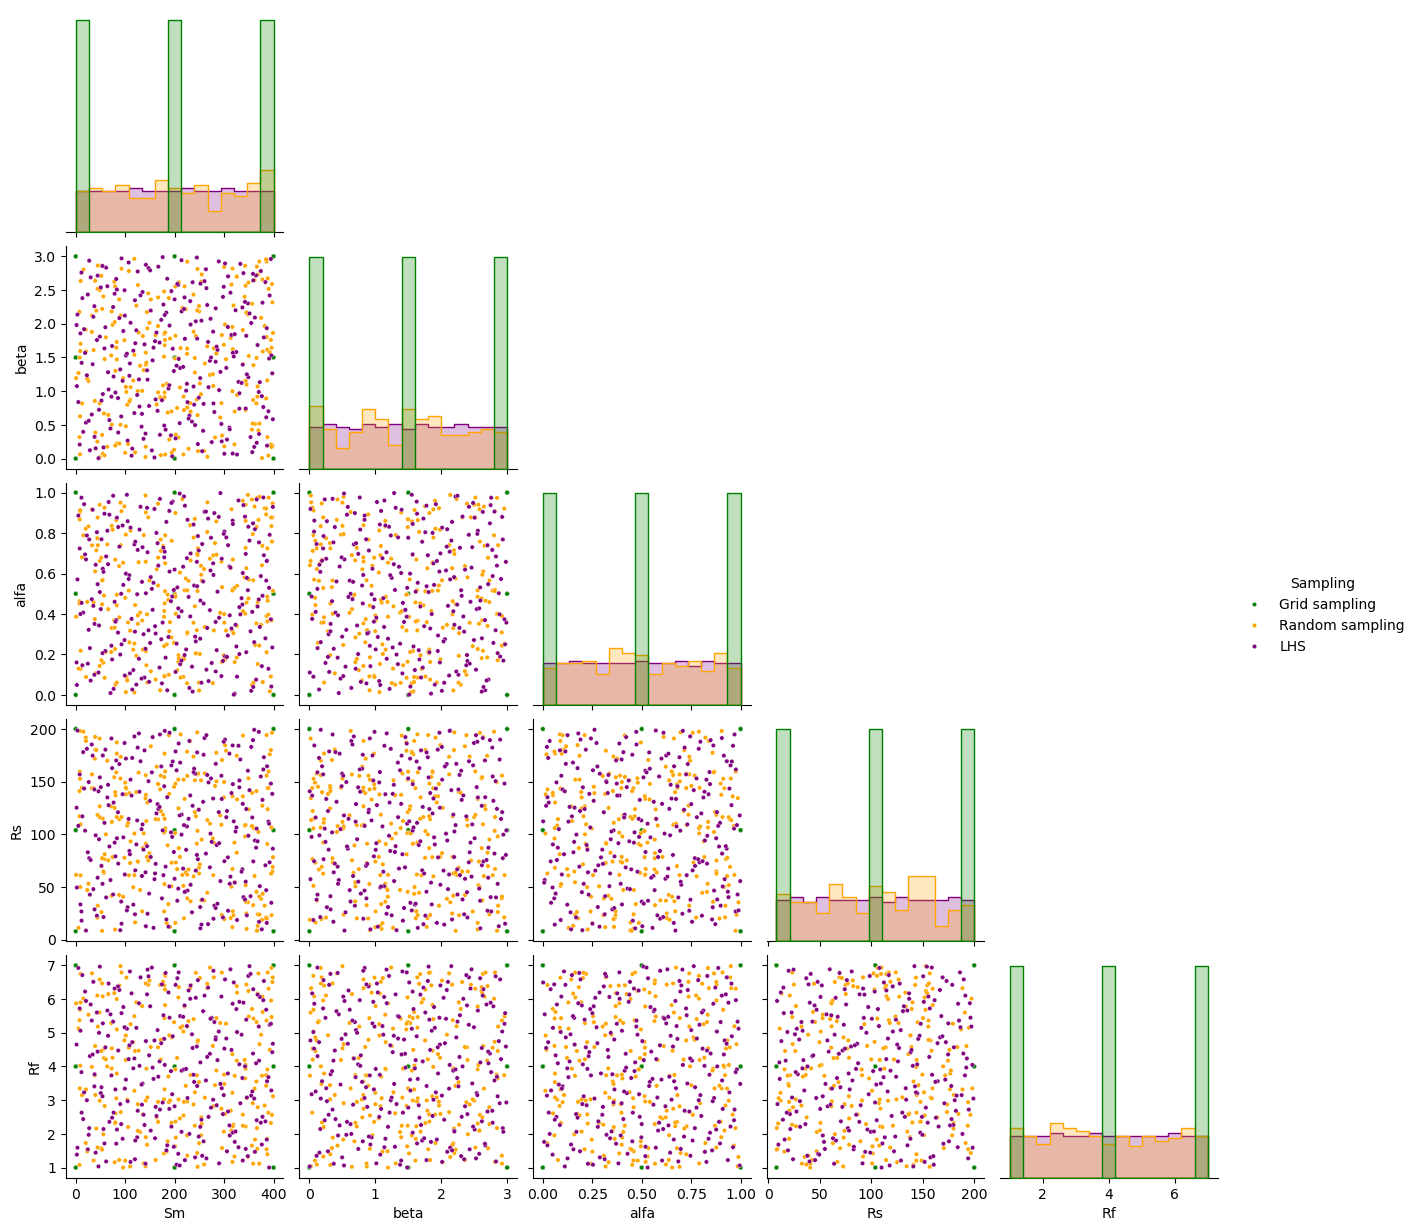

In [16]:
sns.pairplot(data=df_pairplot, corner=True, hue="Sampling", diag_kind="hist", palette=colors, 
             diag_kws=dict(element="step", bins=bins, stat="percent"),
             plot_kws=dict(s=10))  # you may change s to alter the marker size
# you can comment out the line above and use the line below to show only "Grid sampling", "Random sampling", and "LHS"
#sns.pairplot(data=df_pairplot[df_pairplot["Sampling"] == "Grid sampling"], corner=True, diag_kind="hist", diag_kws=dict(element="step", bins=bins))

<div style="background:#e0f2fe;padding:1%;border:1mm solid SkyBlue">
    <h4><span>&#129300 </span>Your Turn I: Parameter Distributions</h4>
    <ol>
        <li>Compare the plots produced with different sample sizes and sampling strategies. What differences between sampling strategies can you spot?</li>
        <li>Imagine each model run would cost you 10 hours of computing time. Which sampling would you prefer?</li>
    </ol>
</div>

**Make histogram of metric results for each sampling strategy**

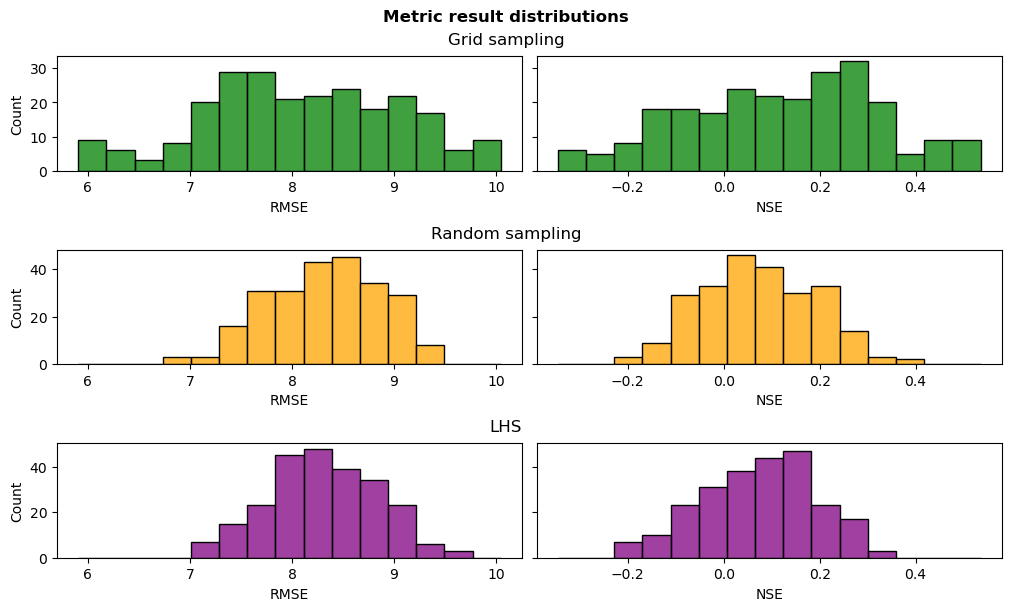

In [7]:
# plot parameter distributions
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
fig.suptitle('Metric result distributions', fontweight="bold")
subfigs = fig.subfigures(nrows=len(dict_dfs), ncols=1)
df_rmse = df_metrics[df_metrics["Metric"] == l_obj_fun_names[0]]
df_nse = df_metrics[df_metrics["Metric"] == l_obj_fun_names[1]]
dict_bounds = {l_obj_fun_names[0]: (df_rmse["Metric value"].min(), df_rmse["Metric value"].max()), 
               l_obj_fun_names[1]: (df_nse["Metric value"].min(), df_nse["Metric value"].max())}
for sampling_name, subfig, color in zip(l_sampling_names, subfigs, colors):
    subfig.suptitle(sampling_name)
    axes = subfig.subplots(nrows=1, ncols=len(dict_obj_fun), sharey=True)
    df_metrics_sampling = df_metrics[(df_metrics["Sampling"] == sampling_name)]
    df_metrics_sampling = df_metrics_sampling[["Set", "Metric value", "Metric"]]
    df_metrics_sampling = pd.pivot_table(df_metrics_sampling, values="Metric value", columns="Metric", index="Set")
    # print(df_metrics_sampling)
    for ax, objective_fun_name, bound in zip(axes, dict_obj_fun.keys(), bounds):
        sns.histplot(df_metrics_sampling[objective_fun_name], bins=bins, ax=ax, binrange=dict_bounds[objective_fun_name], color=color)


**Make scatterplot of metric result (NSE/RMSE) against parameter value for each sampling strategy**

Using RMSE. Keep in mind that this metric is optimal at 0.


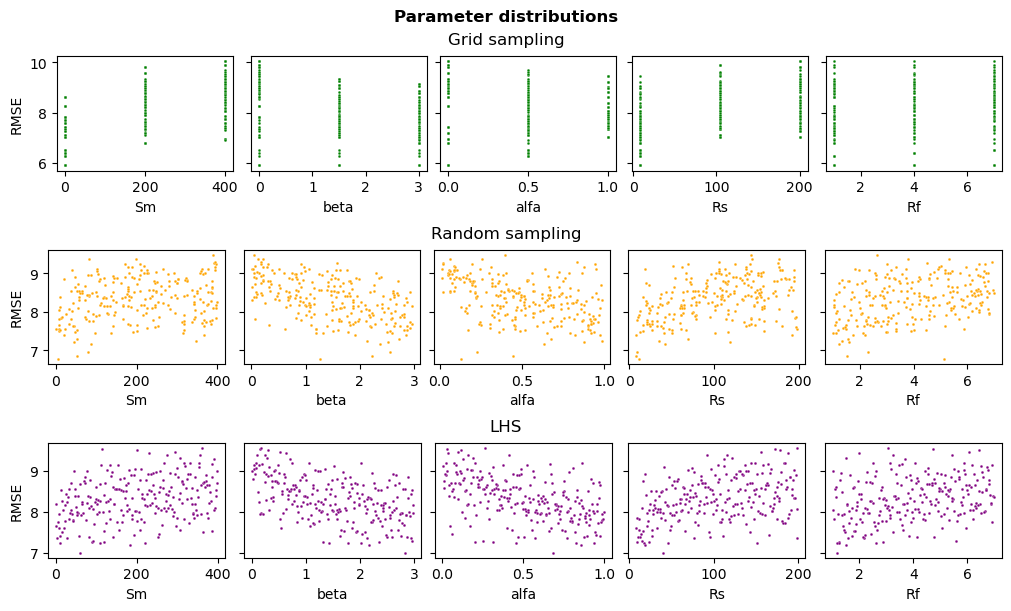

In [8]:
metric_name = "RMSE"  # options: "NSE", "RMSE"
if metric_name == "RMSE":
    print("Using RMSE. Keep in mind that this metric is optimal at 0.")
if metric_name == "NSE":
    print("Using NSE. Keep in mind that this metric is optimal at 1.")
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
fig.suptitle('Parameter distributions', fontweight="bold")
subfigs = fig.subfigures(nrows=len(dict_dfs), ncols=1)
l_df_smp = []
for sampling_name, df_smp, subfig, color in zip(dict_dfs, dict_dfs.values(), subfigs, colors):
    subfig.suptitle(sampling_name)
    axes = subfig.subplots(nrows=1, ncols=len(parameter_names), sharey=True)
    for ax, parameter_name, bound in zip(axes, parameter_names, bounds):
        df_scatter = df_metrics[(df_metrics["Sampling"] == sampling_name) & 
                                (df_metrics["Metric"] == metric_name) & 
                                (df_metrics["Parameter"] == parameter_name)]
        # print(df_scatter)
        sns.scatterplot(df_scatter, x="Parameter value", y="Metric value", ax=ax, color=color, s=4)  # you may change s to alter the marker size 
        ax.set_xlabel(parameter_name)
        ax.set_ylabel(metric_name)

<div style="background:#e0f2fe;padding:1%;border:1mm solid SkyBlue">
    <h4><span>&#129300 </span>Your Turn II: Examining Metric Results of Sampled Parameters</h4>
    <ol>
        <li>What can you learn about the parameter bounds?</li>
        <li>Do you have an equifinality problem? What can you do about it?</li>
        <li>What do the sampling results tell you about the optimum parameter set?</li>
        <li>What can you say about interactions of pairs of parameters?</li>
    </ol>
</div>